# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

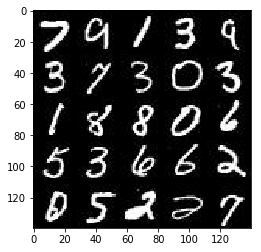

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

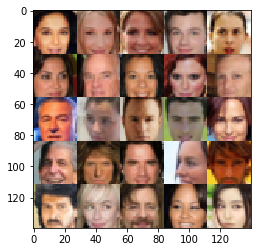

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32,shape=(None,image_width,image_height,image_channels),name='input_real') 
    inputs_z = tf.placeholder(tf.float32,(None, z_dim),name='input_z')    
    learn_rate = tf.placeholder(tf.float32,name='learning_rate')
    
    return inputs_real,inputs_z,learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        conv1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        
        #Conv2         
        conv2 = tf.layers.conv2d(relu1, 128, 3, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)

        #Conv3
        conv3 = tf.layers.conv2d(relu2, 256, 3, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        #Conv4
        conv4 = tf.layers.conv2d(relu3, 512, 3, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(conv4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        # Flatten it
        #print(relu4.shape)
        flat = tf.reshape(relu4, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator', reuse=not(is_train)):
        # First fully connected layer
        fully_connected = tf.layers.dense(z, 7*7*512)
        # Reshape
        fully_connected = tf.reshape(fully_connected, (-1, 7, 7, 512))
        fully_connected = tf.layers.batch_normalization(fully_connected, training=is_train)
        fully_connected = tf.maximum(alpha * fully_connected, fully_connected)

        
        convt1 = tf.layers.conv2d_transpose(fully_connected, 256, 3, strides=1, padding='same')
        convt1 = tf.layers.batch_normalization(convt1, training=is_train)
        convt1 = tf.maximum(alpha * convt1, convt1)
 
        
        convt2 = tf.layers.conv2d_transpose(convt1, 128, 3, strides=1, padding='same')
        convt2 = tf.layers.batch_normalization(convt2, training=is_train)
        convt2 = tf.maximum(alpha * convt2, convt2)
        
        convt3 = tf.layers.conv2d_transpose(convt2, 64, 3, strides=2, padding='same')
        convt3 = tf.layers.batch_normalization(convt3, training=is_train)
        convt3 = tf.maximum(alpha * convt3, convt3)

        # Output layer
        logits = tf.layers.conv2d_transpose(convt3, out_channel_dim, 3, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real,input_z,learn_rate = model_inputs(image_width,image_height,image_channels,z_dim)
    d_loss,g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images=batch_images*2              
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real:batch_images,input_z:batch_z,learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z,learn_rate:learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.5471... Generator Loss: 0.1127
Epoch 1/2... Discriminator Loss: 2.4983... Generator Loss: 1.8573
Epoch 1/2... Discriminator Loss: 1.5247... Generator Loss: 3.8329
Epoch 1/2... Discriminator Loss: 4.9136... Generator Loss: 0.2833
Epoch 1/2... Discriminator Loss: 1.5588... Generator Loss: 4.8098
Epoch 1/2... Discriminator Loss: 2.0453... Generator Loss: 4.7160
Epoch 1/2... Discriminator Loss: 2.7228... Generator Loss: 0.4349
Epoch 1/2... Discriminator Loss: 2.6948... Generator Loss: 5.4041
Epoch 1/2... Discriminator Loss: 2.0568... Generator Loss: 0.3082
Epoch 1/2... Discriminator Loss: 2.8905... Generator Loss: 0.2000


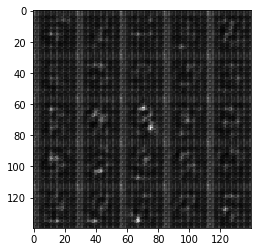

Epoch 1/2... Discriminator Loss: 3.0863... Generator Loss: 0.1652
Epoch 1/2... Discriminator Loss: 1.5054... Generator Loss: 1.8784
Epoch 1/2... Discriminator Loss: 1.8927... Generator Loss: 3.4969
Epoch 1/2... Discriminator Loss: 2.0863... Generator Loss: 4.1357
Epoch 1/2... Discriminator Loss: 1.7274... Generator Loss: 0.4460
Epoch 1/2... Discriminator Loss: 2.8164... Generator Loss: 0.1338
Epoch 1/2... Discriminator Loss: 1.1399... Generator Loss: 1.3721
Epoch 1/2... Discriminator Loss: 3.1501... Generator Loss: 5.0727
Epoch 1/2... Discriminator Loss: 1.2496... Generator Loss: 1.7352
Epoch 1/2... Discriminator Loss: 2.3800... Generator Loss: 0.2769


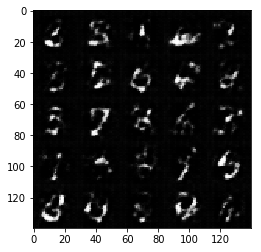

Epoch 1/2... Discriminator Loss: 1.8639... Generator Loss: 0.4042
Epoch 1/2... Discriminator Loss: 1.1087... Generator Loss: 1.8835
Epoch 1/2... Discriminator Loss: 2.2841... Generator Loss: 3.4860
Epoch 1/2... Discriminator Loss: 1.3869... Generator Loss: 2.2853
Epoch 1/2... Discriminator Loss: 0.9778... Generator Loss: 1.3898
Epoch 1/2... Discriminator Loss: 1.0546... Generator Loss: 1.8758
Epoch 1/2... Discriminator Loss: 2.7718... Generator Loss: 0.1757
Epoch 1/2... Discriminator Loss: 2.6592... Generator Loss: 0.1779
Epoch 1/2... Discriminator Loss: 2.0526... Generator Loss: 3.5138
Epoch 1/2... Discriminator Loss: 1.1169... Generator Loss: 1.1938


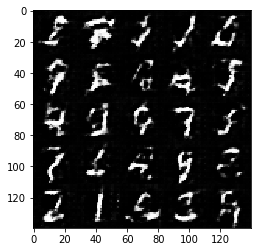

Epoch 1/2... Discriminator Loss: 1.5776... Generator Loss: 0.4724
Epoch 1/2... Discriminator Loss: 3.3197... Generator Loss: 0.1541
Epoch 1/2... Discriminator Loss: 1.2993... Generator Loss: 0.8423
Epoch 1/2... Discriminator Loss: 1.4735... Generator Loss: 0.5879
Epoch 1/2... Discriminator Loss: 0.9857... Generator Loss: 1.8937
Epoch 1/2... Discriminator Loss: 1.2587... Generator Loss: 0.6938
Epoch 1/2... Discriminator Loss: 1.4207... Generator Loss: 0.8279
Epoch 1/2... Discriminator Loss: 0.9074... Generator Loss: 1.4394
Epoch 1/2... Discriminator Loss: 4.7719... Generator Loss: 5.6874
Epoch 1/2... Discriminator Loss: 2.0137... Generator Loss: 0.3583


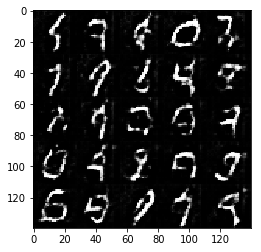

Epoch 1/2... Discriminator Loss: 1.2600... Generator Loss: 0.9149
Epoch 1/2... Discriminator Loss: 1.7814... Generator Loss: 0.4368
Epoch 1/2... Discriminator Loss: 2.5327... Generator Loss: 5.2284
Epoch 1/2... Discriminator Loss: 2.7822... Generator Loss: 0.2235
Epoch 1/2... Discriminator Loss: 1.2266... Generator Loss: 0.6765
Epoch 1/2... Discriminator Loss: 0.7886... Generator Loss: 1.8600
Epoch 1/2... Discriminator Loss: 4.1730... Generator Loss: 6.1938
Epoch 1/2... Discriminator Loss: 1.6306... Generator Loss: 2.9723
Epoch 1/2... Discriminator Loss: 1.7215... Generator Loss: 2.8925
Epoch 1/2... Discriminator Loss: 1.2030... Generator Loss: 0.8778


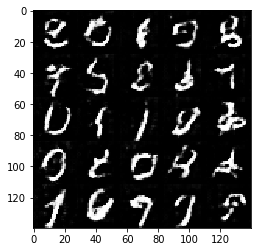

Epoch 1/2... Discriminator Loss: 1.6931... Generator Loss: 0.4430
Epoch 1/2... Discriminator Loss: 1.6888... Generator Loss: 4.1569
Epoch 1/2... Discriminator Loss: 0.9597... Generator Loss: 1.4822
Epoch 1/2... Discriminator Loss: 2.5749... Generator Loss: 0.2501
Epoch 1/2... Discriminator Loss: 1.2415... Generator Loss: 1.4467
Epoch 1/2... Discriminator Loss: 1.2898... Generator Loss: 0.8169
Epoch 1/2... Discriminator Loss: 2.2153... Generator Loss: 4.0251
Epoch 1/2... Discriminator Loss: 1.2189... Generator Loss: 2.0173
Epoch 1/2... Discriminator Loss: 1.7040... Generator Loss: 0.4062
Epoch 1/2... Discriminator Loss: 0.8793... Generator Loss: 1.1663


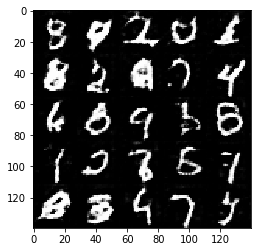

Epoch 1/2... Discriminator Loss: 0.9128... Generator Loss: 1.1618
Epoch 1/2... Discriminator Loss: 1.0805... Generator Loss: 0.8729
Epoch 1/2... Discriminator Loss: 1.1511... Generator Loss: 0.7567
Epoch 1/2... Discriminator Loss: 0.6267... Generator Loss: 1.8400
Epoch 1/2... Discriminator Loss: 1.8652... Generator Loss: 4.2324
Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 1.4098
Epoch 1/2... Discriminator Loss: 1.0173... Generator Loss: 2.1620
Epoch 1/2... Discriminator Loss: 0.9970... Generator Loss: 1.7440
Epoch 1/2... Discriminator Loss: 0.8767... Generator Loss: 1.2624
Epoch 1/2... Discriminator Loss: 4.9152... Generator Loss: 0.0388


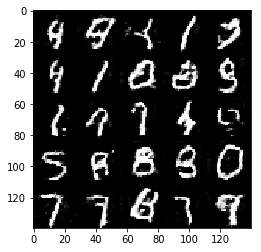

Epoch 1/2... Discriminator Loss: 1.5157... Generator Loss: 0.6398
Epoch 1/2... Discriminator Loss: 1.9209... Generator Loss: 3.7756
Epoch 1/2... Discriminator Loss: 1.4991... Generator Loss: 0.5068
Epoch 1/2... Discriminator Loss: 0.8313... Generator Loss: 1.3046
Epoch 1/2... Discriminator Loss: 2.0344... Generator Loss: 3.6600
Epoch 1/2... Discriminator Loss: 1.7835... Generator Loss: 0.4740
Epoch 1/2... Discriminator Loss: 1.1397... Generator Loss: 0.9284
Epoch 1/2... Discriminator Loss: 1.2237... Generator Loss: 2.8163
Epoch 1/2... Discriminator Loss: 1.2341... Generator Loss: 0.7792
Epoch 1/2... Discriminator Loss: 1.3968... Generator Loss: 0.5411


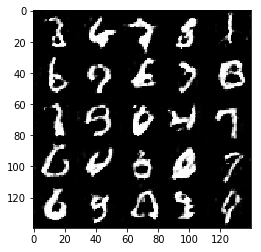

Epoch 1/2... Discriminator Loss: 0.8671... Generator Loss: 1.8618
Epoch 1/2... Discriminator Loss: 0.8254... Generator Loss: 2.6301
Epoch 1/2... Discriminator Loss: 1.1577... Generator Loss: 0.8060
Epoch 1/2... Discriminator Loss: 1.0769... Generator Loss: 1.2000
Epoch 1/2... Discriminator Loss: 1.2788... Generator Loss: 2.2245
Epoch 1/2... Discriminator Loss: 1.8230... Generator Loss: 0.4563
Epoch 1/2... Discriminator Loss: 0.8141... Generator Loss: 1.3514
Epoch 1/2... Discriminator Loss: 1.4039... Generator Loss: 2.8330
Epoch 1/2... Discriminator Loss: 0.7200... Generator Loss: 1.8519
Epoch 1/2... Discriminator Loss: 0.7677... Generator Loss: 1.3036


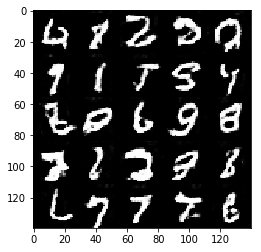

Epoch 1/2... Discriminator Loss: 0.9149... Generator Loss: 1.3661
Epoch 1/2... Discriminator Loss: 1.1878... Generator Loss: 2.3852
Epoch 1/2... Discriminator Loss: 1.0420... Generator Loss: 1.0815
Epoch 2/2... Discriminator Loss: 0.9332... Generator Loss: 1.2239
Epoch 2/2... Discriminator Loss: 1.6300... Generator Loss: 1.0087
Epoch 2/2... Discriminator Loss: 1.0149... Generator Loss: 3.0226
Epoch 2/2... Discriminator Loss: 1.5053... Generator Loss: 0.7079
Epoch 2/2... Discriminator Loss: 1.0023... Generator Loss: 3.3335
Epoch 2/2... Discriminator Loss: 1.4870... Generator Loss: 0.5402
Epoch 2/2... Discriminator Loss: 3.0656... Generator Loss: 6.0615


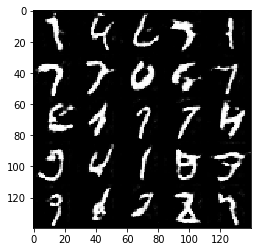

Epoch 2/2... Discriminator Loss: 1.3137... Generator Loss: 0.7423
Epoch 2/2... Discriminator Loss: 1.0679... Generator Loss: 1.1766
Epoch 2/2... Discriminator Loss: 1.1494... Generator Loss: 1.9203
Epoch 2/2... Discriminator Loss: 0.9393... Generator Loss: 1.5644
Epoch 2/2... Discriminator Loss: 1.6464... Generator Loss: 0.4908
Epoch 2/2... Discriminator Loss: 1.6836... Generator Loss: 0.5089
Epoch 2/2... Discriminator Loss: 1.0230... Generator Loss: 0.9943
Epoch 2/2... Discriminator Loss: 0.6803... Generator Loss: 1.4756
Epoch 2/2... Discriminator Loss: 0.9113... Generator Loss: 1.1488
Epoch 2/2... Discriminator Loss: 0.8107... Generator Loss: 1.3683


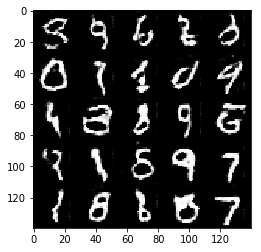

Epoch 2/2... Discriminator Loss: 1.9371... Generator Loss: 5.0257
Epoch 2/2... Discriminator Loss: 1.1979... Generator Loss: 1.8009
Epoch 2/2... Discriminator Loss: 1.5669... Generator Loss: 0.5694
Epoch 2/2... Discriminator Loss: 1.0786... Generator Loss: 3.3940
Epoch 2/2... Discriminator Loss: 1.0476... Generator Loss: 1.0495
Epoch 2/2... Discriminator Loss: 0.6657... Generator Loss: 1.9912
Epoch 2/2... Discriminator Loss: 0.8133... Generator Loss: 1.4479
Epoch 2/2... Discriminator Loss: 3.4025... Generator Loss: 6.2441
Epoch 2/2... Discriminator Loss: 1.3142... Generator Loss: 3.8786
Epoch 2/2... Discriminator Loss: 1.8440... Generator Loss: 0.4833


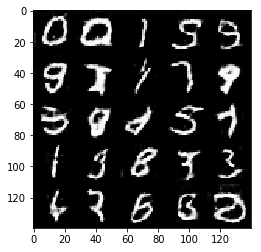

Epoch 2/2... Discriminator Loss: 0.9263... Generator Loss: 1.6777
Epoch 2/2... Discriminator Loss: 1.4126... Generator Loss: 0.6615
Epoch 2/2... Discriminator Loss: 1.0397... Generator Loss: 2.9100
Epoch 2/2... Discriminator Loss: 0.8917... Generator Loss: 1.3258
Epoch 2/2... Discriminator Loss: 0.7232... Generator Loss: 1.5962
Epoch 2/2... Discriminator Loss: 1.3260... Generator Loss: 0.9440
Epoch 2/2... Discriminator Loss: 1.0242... Generator Loss: 1.5445
Epoch 2/2... Discriminator Loss: 1.2140... Generator Loss: 3.6033
Epoch 2/2... Discriminator Loss: 0.7755... Generator Loss: 1.4071
Epoch 2/2... Discriminator Loss: 0.8776... Generator Loss: 1.3678


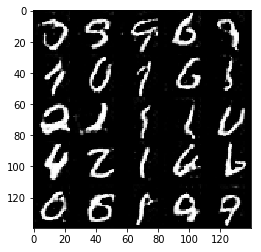

Epoch 2/2... Discriminator Loss: 1.0000... Generator Loss: 1.1539
Epoch 2/2... Discriminator Loss: 0.6445... Generator Loss: 2.4138
Epoch 2/2... Discriminator Loss: 0.8128... Generator Loss: 1.6443
Epoch 2/2... Discriminator Loss: 2.0228... Generator Loss: 0.3323
Epoch 2/2... Discriminator Loss: 0.9399... Generator Loss: 1.5722
Epoch 2/2... Discriminator Loss: 1.4489... Generator Loss: 1.0604
Epoch 2/2... Discriminator Loss: 0.9420... Generator Loss: 1.1189
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 0.9878
Epoch 2/2... Discriminator Loss: 1.1036... Generator Loss: 0.9443
Epoch 2/2... Discriminator Loss: 0.7258... Generator Loss: 1.4957


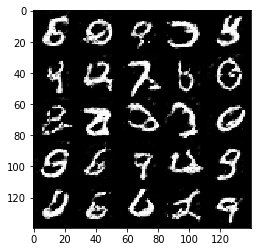

Epoch 2/2... Discriminator Loss: 0.6421... Generator Loss: 1.8544
Epoch 2/2... Discriminator Loss: 0.6811... Generator Loss: 1.6334
Epoch 2/2... Discriminator Loss: 0.6778... Generator Loss: 1.8373
Epoch 2/2... Discriminator Loss: 2.3055... Generator Loss: 5.2247
Epoch 2/2... Discriminator Loss: 1.1719... Generator Loss: 1.1923
Epoch 2/2... Discriminator Loss: 0.5474... Generator Loss: 2.7182
Epoch 2/2... Discriminator Loss: 0.5613... Generator Loss: 2.2626
Epoch 2/2... Discriminator Loss: 0.8310... Generator Loss: 1.3546
Epoch 2/2... Discriminator Loss: 0.9140... Generator Loss: 1.7661
Epoch 2/2... Discriminator Loss: 2.5116... Generator Loss: 5.9106


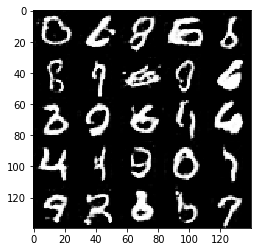

Epoch 2/2... Discriminator Loss: 1.3053... Generator Loss: 0.8879
Epoch 2/2... Discriminator Loss: 1.2446... Generator Loss: 0.7888
Epoch 2/2... Discriminator Loss: 0.9016... Generator Loss: 1.2324
Epoch 2/2... Discriminator Loss: 2.0902... Generator Loss: 0.3447
Epoch 2/2... Discriminator Loss: 0.8348... Generator Loss: 1.2563
Epoch 2/2... Discriminator Loss: 1.5445... Generator Loss: 0.6142
Epoch 2/2... Discriminator Loss: 1.3586... Generator Loss: 0.7746
Epoch 2/2... Discriminator Loss: 1.5997... Generator Loss: 0.5913
Epoch 2/2... Discriminator Loss: 0.9411... Generator Loss: 1.4168
Epoch 2/2... Discriminator Loss: 1.0495... Generator Loss: 3.0999


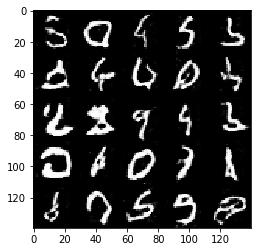

Epoch 2/2... Discriminator Loss: 1.3857... Generator Loss: 0.6976
Epoch 2/2... Discriminator Loss: 0.5675... Generator Loss: 2.3381
Epoch 2/2... Discriminator Loss: 0.5894... Generator Loss: 2.1061
Epoch 2/2... Discriminator Loss: 0.6283... Generator Loss: 1.8522
Epoch 2/2... Discriminator Loss: 1.3626... Generator Loss: 0.8029
Epoch 2/2... Discriminator Loss: 0.5260... Generator Loss: 2.9648
Epoch 2/2... Discriminator Loss: 0.5365... Generator Loss: 2.1780
Epoch 2/2... Discriminator Loss: 0.6185... Generator Loss: 1.8015
Epoch 2/2... Discriminator Loss: 0.5966... Generator Loss: 2.9691
Epoch 2/2... Discriminator Loss: 0.9504... Generator Loss: 1.7574


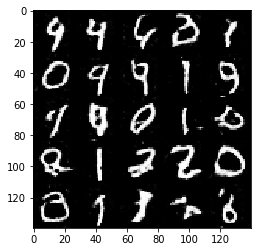

Epoch 2/2... Discriminator Loss: 1.5132... Generator Loss: 0.6586
Epoch 2/2... Discriminator Loss: 0.8057... Generator Loss: 1.7238
Epoch 2/2... Discriminator Loss: 0.6478... Generator Loss: 1.9646
Epoch 2/2... Discriminator Loss: 0.7490... Generator Loss: 1.6430
Epoch 2/2... Discriminator Loss: 0.6238... Generator Loss: 1.8254
Epoch 2/2... Discriminator Loss: 0.5708... Generator Loss: 2.0661
Epoch 2/2... Discriminator Loss: 3.9349... Generator Loss: 7.9359
Epoch 2/2... Discriminator Loss: 2.3275... Generator Loss: 0.2976
Epoch 2/2... Discriminator Loss: 1.0942... Generator Loss: 0.9641
Epoch 2/2... Discriminator Loss: 0.7430... Generator Loss: 1.5922


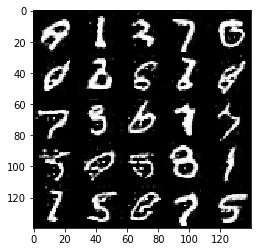

Epoch 2/2... Discriminator Loss: 0.6147... Generator Loss: 1.9407
Epoch 2/2... Discriminator Loss: 2.0485... Generator Loss: 0.5329
Epoch 2/2... Discriminator Loss: 1.0515... Generator Loss: 1.0855
Epoch 2/2... Discriminator Loss: 1.3720... Generator Loss: 0.8336
Epoch 2/2... Discriminator Loss: 0.6346... Generator Loss: 2.0135
Epoch 2/2... Discriminator Loss: 0.7881... Generator Loss: 1.5447
Epoch 2/2... Discriminator Loss: 0.9610... Generator Loss: 2.6037


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 1.3289
Epoch 1/1... Discriminator Loss: 0.6204... Generator Loss: 1.7020
Epoch 1/1... Discriminator Loss: 0.4763... Generator Loss: 2.4498
Epoch 1/1... Discriminator Loss: 0.4810... Generator Loss: 2.4230
Epoch 1/1... Discriminator Loss: 0.4385... Generator Loss: 3.3191
Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 3.4937
Epoch 1/1... Discriminator Loss: 0.3826... Generator Loss: 4.7696
Epoch 1/1... Discriminator Loss: 0.4895... Generator Loss: 2.2644
Epoch 1/1... Discriminator Loss: 0.3813... Generator Loss: 4.4560
Epoch 1/1... Discriminator Loss: 0.4124... Generator Loss: 3.7258


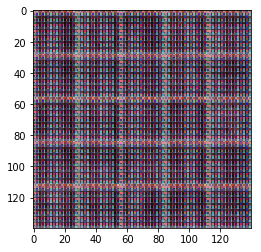

Epoch 1/1... Discriminator Loss: 0.5901... Generator Loss: 3.7263
Epoch 1/1... Discriminator Loss: 0.7147... Generator Loss: 2.9059
Epoch 1/1... Discriminator Loss: 0.6911... Generator Loss: 1.8980
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 0.7229... Generator Loss: 1.5713
Epoch 1/1... Discriminator Loss: 0.7264... Generator Loss: 3.5547
Epoch 1/1... Discriminator Loss: 0.6557... Generator Loss: 2.4443
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 0.6331... Generator Loss: 2.2066
Epoch 1/1... Discriminator Loss: 0.6348... Generator Loss: 1.8869


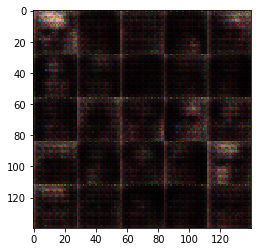

Epoch 1/1... Discriminator Loss: 0.7897... Generator Loss: 2.3098
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 0.7410... Generator Loss: 1.5966
Epoch 1/1... Discriminator Loss: 0.8070... Generator Loss: 1.3400
Epoch 1/1... Discriminator Loss: 1.6315... Generator Loss: 0.4639
Epoch 1/1... Discriminator Loss: 0.6353... Generator Loss: 2.0929
Epoch 1/1... Discriminator Loss: 0.8396... Generator Loss: 1.1988
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 4.4245
Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 1.0931


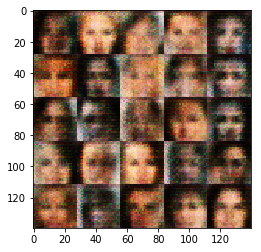

Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 1.7190
Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 2.3191
Epoch 1/1... Discriminator Loss: 0.6862... Generator Loss: 1.6444
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 0.7802... Generator Loss: 1.8779
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 2.8527
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 0.8328... Generator Loss: 1.2926
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 0.8652... Generator Loss: 1.2496


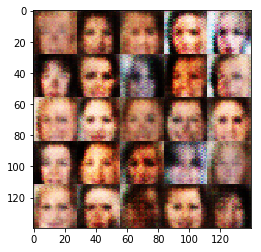

Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 1.3319
Epoch 1/1... Discriminator Loss: 0.8466... Generator Loss: 1.7443
Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 1.3003
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.5668
Epoch 1/1... Discriminator Loss: 0.9225... Generator Loss: 1.4035
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 1.0238
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 1.1170


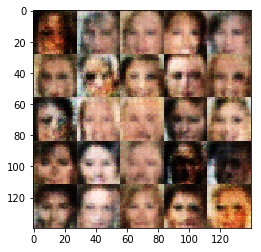

Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 1.1118
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 2.5623
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 1.8493
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.1387
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 2.4497
Epoch 1/1... Discriminator Loss: 0.9620... Generator Loss: 1.7000
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 1.1002


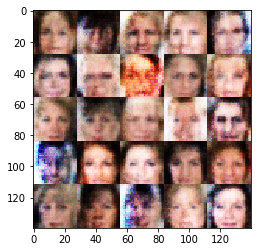

Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 1.6067
Epoch 1/1... Discriminator Loss: 0.9370... Generator Loss: 1.2930
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.2515
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 2.0621
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 1.9201
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.1823
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 2.3571


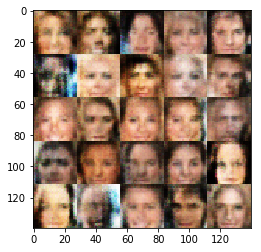

Epoch 1/1... Discriminator Loss: 0.8748... Generator Loss: 1.6070
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 1.8285
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.4892
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 1.3290
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 1.4269
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 1.4305
Epoch 1/1... Discriminator Loss: 0.9942... Generator Loss: 1.2549
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 0.8778


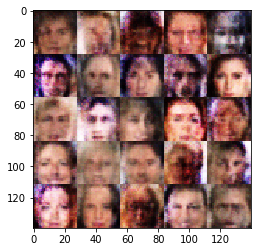

Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 2.0945
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 1.6640
Epoch 1/1... Discriminator Loss: 0.9125... Generator Loss: 1.1440
Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 1.3061
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 1.9854
Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 1.7469
Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 1.5416
Epoch 1/1... Discriminator Loss: 0.8967... Generator Loss: 1.4898
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.4607


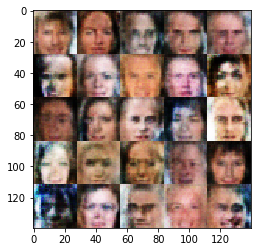

Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 1.1007
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 0.9429
Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 1.3543
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 1.1778
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.5434
Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 1.1123
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 1.0209
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.6020


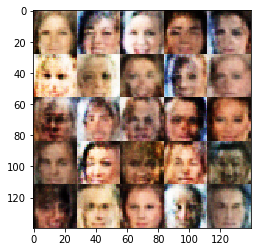

Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 1.0333
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.5364
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 1.7696
Epoch 1/1... Discriminator Loss: 1.7900... Generator Loss: 2.4983
Epoch 1/1... Discriminator Loss: 0.9151... Generator Loss: 1.3139
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 1.4200
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 1.1971


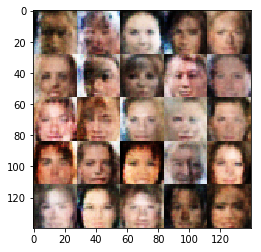

Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.1054
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 1.1651
Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 1.6170
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 1.0908
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 2.2305
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.4507


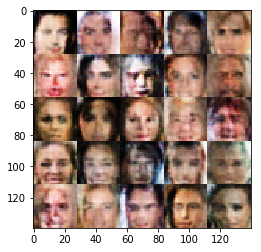

Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 1.1832
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 0.9345... Generator Loss: 1.1135
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 1.3682
Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.6693


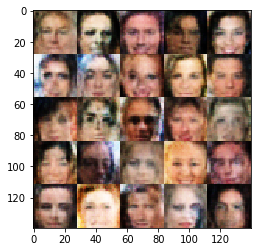

Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 1.2559
Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 1.3145
Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 1.2937
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.5235
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 1.3224
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 1.8520
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 1.3992
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.4407


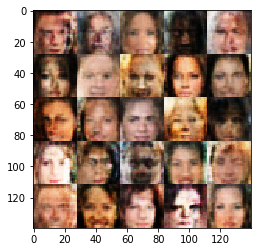

Epoch 1/1... Discriminator Loss: 0.7364... Generator Loss: 1.5740
Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 1.2267
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.5385
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 1.6667
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 0.7972... Generator Loss: 1.3568
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.7331


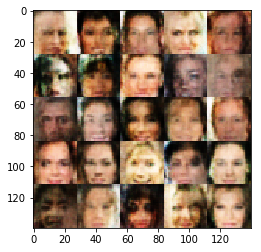

Epoch 1/1... Discriminator Loss: 0.7573... Generator Loss: 1.5061
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 2.4233
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 1.1098
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 1.0827
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 1.1555
Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 1.4449
Epoch 1/1... Discriminator Loss: 0.8455... Generator Loss: 1.1868
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.7739


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.